# Association Rules
## Example with the [__Online Retail__](https://archive.ics.uci.edu/ml/datasets/online+retail) dataset, from UCI

Code provided in this [link](http://pbpython.com/market-basket-analysis.html)

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules 

url = 'Online-Retail.csv'
random_state = 42

Upload the file `'Online-Retail.xlsx'`. It is a MS Excel file, you can read it with the Pandas' function `read_excel` (it might take a while, use the csv version of the dataset if the process is too slow).

Inspect its content. It is a transactional database where the role of transaction identifier is played by the column `InvoiceNo` and the items are in the column `Description`.

The database has some problems:
1. some descriptions represent the same item but have different leading or trailing spaces, therefore they must be made uniform with the Pandas' function `str.strip()`

In [47]:
df = pd.read_csv(url)
df.head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
5,536365,22752,SET 7 BABUSHKA NESTING BOXES,2,2010-12-01 08:26:00,7.65,17850.0,United Kingdom
6,536365,21730,GLASS STAR FROSTED T-LIGHT HOLDER,6,2010-12-01 08:26:00,4.25,17850.0,United Kingdom
7,536366,22633,HAND WARMER UNION JACK,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
8,536366,22632,HAND WARMER RED POLKA DOT,6,2010-12-01 08:28:00,1.85,17850.0,United Kingdom
9,NaN,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [48]:
for i in df.columns:
    print('The number of unique {} values in the input file is {}'.format(i, len(df[i].unique())))

The number of unique InvoiceNo values in the input file is 25901
The number of unique StockCode values in the input file is 4070
The number of unique Description values in the input file is 4224
The number of unique Quantity values in the input file is 722
The number of unique InvoiceDate values in the input file is 23260
The number of unique UnitPrice values in the input file is 1630
The number of unique CustomerID values in the input file is 4373
The number of unique Country values in the input file is 38


In [49]:
#rimozione delle righe con description con spazi extra
df['Description'] = df['Description'].str.strip()
print("After cleaning, the number of unique Description values in the input file is {}".format(len(df['Description'].unique())))

After cleaning, the number of unique Description values in the input file is 4212


Some rows may not have an `InvoiceNo` and must be removed, because they cannot be used.

Check if there are such that rows and in case remove them. You can check with the Pandas' function `isna` and remove with `dropna` on `axis=0`, with the option `subset`

In [50]:
print('Rows that need to be removed: {}'.format(len(df[df['InvoiceNo'].isna()])))
df[df['InvoiceNo'].isna()]
        

Rows that need to be removed: 1


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
9,NaN,84879,ASSORTED COLOUR BIRD ORNAMENT,32,2010-12-01 08:34:00,1.69,13047.0,United Kingdom


In [51]:
df.dropna(subset='InvoiceNo', axis=0, inplace=True)
print('Rows that need to be removed: {}'.format(len(df[df['InvoiceNo'].isna()])))

Rows that need to be removed: 0


Some InvoiceNo start with a `C`. They are "credit transactions" and must be removed.

Check the number of rows containing `C` in `InvoiceNo` and remove them.
At the moment the column `InvoiceNo` is a generic object, in order to be
able to use string functions, such as `contains`, it must be transformed into `str` with `astype`.

In [52]:
n_to_drop = len(df[df['InvoiceNo'].astype('str').str.contains('C')])
print('Will drop {} rows with InvoiceNo startting with "C"'.format(n_to_drop))

df = df[df['InvoiceNo'].astype('str').str.contains('C') == False]

Will drop 9288 rows with InvoiceNo startting with "C"


Several transactions include the item `'POSTAGE'`,
which represents the mailing expenses.
In this analysis we are not interested in it, therefore the rows
with `'POSTAGE'` will be removed.

In [53]:
n_to_drop = len(df[df['Description'].astype('str').str.contains('POSTAGE')])
print('Will drop {} rows with Description including "POSTAGE"'.format(n_to_drop))
df = df[df['Description'].astype('str').str.contains('POSTAGE') == False]

Will drop 1834 rows with Description including "POSTAGE"


After the cleanup, we need to consolidate the items into 1 transaction per row with each product 1 hot encoded. For the sake of keeping the data set small, we are only looking at sales for France. However, in additional code below, we will compare these results to sales from Germany. Further country comparisons would be interesting to investigate.

Actions:
1. filter the rows ``Country`='France'`
2. group by `['InvoiceNo', 'Description']` computing a sum on `['Quantity']`
3. use the `unstack` function to move the items from rows to columns
4. reset the index
5. fill the missing with zero (`fillna(0)`)
6. store the result in the new dataframe `basket` and inspect it

In [68]:
basket = (df[df['Country'] =="France"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 EGG HOUSE PAINTED WOOD,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,12 PENCILS TALL TUBE POSY,12 PENCILS TALL TUBE RED RETROSPOT,12 PENCILS TALL TUBE WOODLAND,...,WRAP VINTAGE PETALS DESIGN,YELLOW COAT RACK PARIS FASHION,YELLOW GIANT GARDEN THERMOMETER,YELLOW SHARK HELICOPTER,ZINC STAR T-LIGHT HOLDER,ZINC FOLKART SLEIGH BELLS,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536370,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536852,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536974,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537065,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
537463,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
580986,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581171,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


There are a lot of zeros in the data but we also need to make sure any positive values are converted to a 1 and anything less than 0 is set to 0.

You can define a function `encode_units` which takes a number and returns 0 if the number is 0 or less, 1 if the number is 1 or more. The function can be applied to `basket` with the Pandas' function `applymap`, the result is stored in the variable `basket_sets`

This step will complete the one hot encoding of the data.

In [69]:
encode_units = lambda x: 0 if x <= 0 else 1
basket_sets = basket.applymap(encode_units)

C:\Users\foxdo\AppData\Local\Temp\ipykernel_20576\3945249297.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_sets = basket.applymap(encode_units)


Now that the data is structured properly, we can generate frequent item sets that have a support of at least 7% (this number was chosen so that we can get enough useful examples):

- generate the `frequent_itemsets` with `apriori`, setting `min_support=0.07` and `use_colnames=True`
- generate the `rules` with `association_rules` using `metric="lift"` and `min_threshold=1`
- show the rules

In [74]:
frequent_itemsets = apriori(basket_sets, min_support=0.07, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
rules

c:\Python39\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
0,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE GREEN),0.103359,0.098191,0.074935,0.725000,7.383553,0.064786,3.279305,0.964225
1,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE PINK),0.098191,0.103359,0.074935,0.763158,7.383553,0.064786,3.785817,0.958700
2,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE GREEN),0.095607,0.098191,0.080103,0.837838,8.532717,0.070716,5.561154,0.976129
3,(ALARM CLOCK BAKELIKE GREEN),(ALARM CLOCK BAKELIKE RED),0.098191,0.095607,0.080103,0.815789,8.532717,0.070716,4.909561,0.978926
4,(ALARM CLOCK BAKELIKE RED),(ALARM CLOCK BAKELIKE PINK),0.095607,0.103359,0.074935,0.783784,7.583108,0.065054,4.146964,0.959901
5,(ALARM CLOCK BAKELIKE PINK),(ALARM CLOCK BAKELIKE RED),0.103359,0.095607,0.074935,0.725000,7.583108,0.065054,3.288701,0.968200
6,(SPACEBOY LUNCH BOX),(DOLLY GIRL LUNCH BOX),0.126615,0.100775,0.072351,0.571429,5.670330,0.059592,2.098191,0.943047
7,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.100775,0.126615,0.072351,0.717949,5.670330,0.059592,3.096547,0.915948
8,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN SPACEBOY),0.170543,0.139535,0.090439,0.530303,3.800505,0.066643,1.831958,0.888385
9,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.139535,0.170543,0.090439,0.648148,3.800505,0.066643,2.357405,0.856371


In order to plot the rules, it is better to sort them according to some metrics.
We will sort on descending confidence and support and plot `'confidence'` and `'support'`.

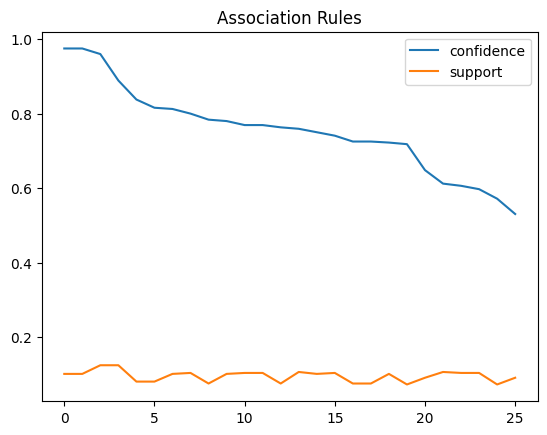

In [75]:
sorted_rules=rules.sort_values(by=['confidence','support'],ascending=False).reset_index(drop=True)
sorted_rules[['confidence','support']].plot(title='Association Rules');

You find below a three dimensional plot, where the dot size is proportional to the lift, obtained using `plot.scatter`.

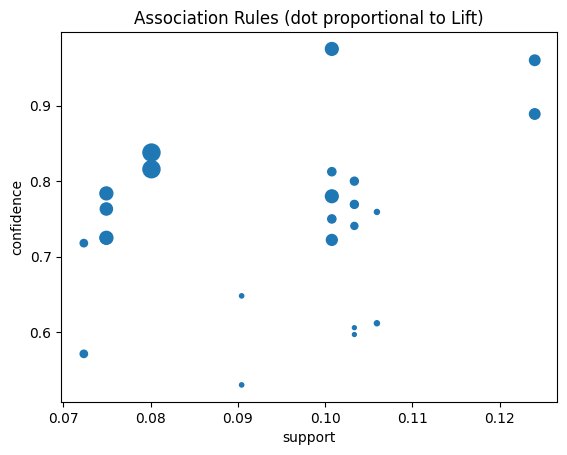

In [82]:
# 1.8 is chosen empirically to obtain the best graphical effect
s = [1.8**n for n in rules.lift]
fig = rules.plot.scatter(x='support', 
                   y='confidence', 
                   title='Association Rules (dot proportional to Lift)', 
                   s=s);

Finally, we draw a plot of a subset of the rules using the function `draw_graph`, provided in this package.

Help on function draw_graph in module draw_rules_graph:

draw_graph(rules, rules_to_show=5)
    draws the rules as a graph linking antecedents and consequents
    "rule nodes" are yellow, with name "R<n>", "item nodes" are green
    arrows colors are different for each rule, and go from the antecedent(s)
    to the rule node and to the consequent(s)
    the "rules_to_show" parameter limits the rules to show to the initial
    part of the "rules" dataframe



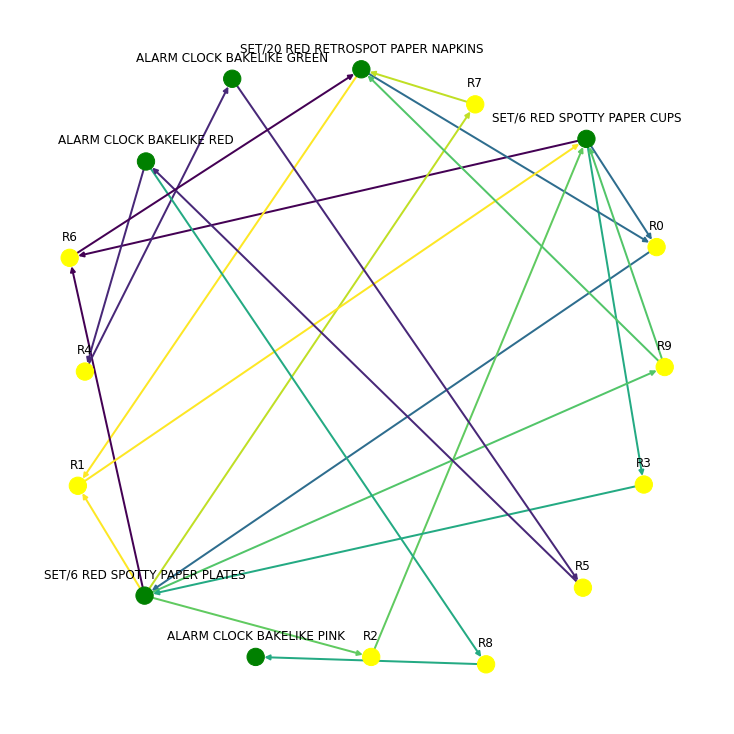

### EXTRA da file di testo a DATAFRAME
da file a transazioni

First transaction:	['InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country']

Second transaction:	['536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom']


Da transazioni a Dataframe  
TRANSACTION ENCODER

MemoryError: Unable to allocate 271. GiB for an array with shape (541910, 536642) and data type bool

### EXTRA Algoritmo apriori con parametri minimi
Find a value of min_support such that the apriori algorithm generates at least 8 frequent itemsets with at least 2 items. Output the result with the message below (5 points)


### EXTRA Algoritmo association rules con parametri minimi
Find the minimum metric threshold such that at least 10 association rules are extracted from the frequent itemsets found (5 points)
_use "confidence" as metric and output the line below:_